## Capstone project Pricify

#### Business Understanding

The goal is to build a model to predict a price for item by picture. As OfferUp says that "With a single snap, you can take a photo of an item and instantly circulate it to people nearby.", it sounds interesting to suggest the price, so you can take a photo of item and decide either you should sell it or not.

### Data Understanding

OfferUp scraping

scrap_offerup.rb  - HTTP Request to https://offerupnow.com/ and scrap the recent offers page by page until the date limit was reached. Each offer was stored into file in JSON format. 

normalize_scraped.rb - Spliting and combining offers into 3 JSON files, I got:
offerup-data
* items.json 605 Mb 380,107 items
* owners.json 141.2 Mb ? item owners
* images.json 214.1 Mb ? links to item images

download_images.rb - 3 size of images organizes into subfolders with offer-id name.
* detail
* full
* list


./scrap_offerup.rb -c /tmp/cookie.txt -s ./scraped -t 0 -n 20000 -p 0.5 | tee scrap.log

In [1]:
import pandas as pd
import matplotlib
%matplotlib inline

In [2]:
df = pd.read_json('../data/items.json')

In [3]:
cdf = df.copy()

In [4]:
df.shape

(380107, 34)

In [5]:
df.head()

,category,condition,description,distance,get_full_url,get_img_medium_height,get_img_medium_width,get_img_permalink_large,get_img_permalink_medium,get_img_permalink_small,...,post_from_store_address,price,priority,reservable,reserved,review_status,sold_date,sold_offer_id,state,title
0,"{u'id': 2, u'name': u'Household'}",40,Colorful mosaic that brightens up a room! 1.5'...,15,https://offerupnow.com/item/detail/96366652/fl...,400,300,https://d2j6tswx2otu6e.cloudfront.net/V_DoSoMA...,https://d2j6tswx2otu6e.cloudfront.net/8toAz7Tj...,https://d2j6tswx2otu6e.cloudfront.net/KPORxbgy...,...,"Lynnwood, WA",10,100,False,False,2,None,NaN,3,Fleur d' lys mosaic artwork
1,"{u'id': 13, u'name': u'Beauty & Health'}",100,2 NYX Avant Pop Palettes. Has 10 different eye...,15,https://offerupnow.com/item/detail/96366557/ny...,400,300,https://d2j6tswx2otu6e.cloudfront.net/lv6RLzOC...,https://d2j6tswx2otu6e.cloudfront.net/z0pDlQul...,https://d2j6tswx2otu6e.cloudfront.net/OujFPQXl...,...,"Lynnwood, WA",25,100,False,False,2,None,NaN,3,NYX Avant Pop Palettes
2,"{u'id': 3, u'name': u'General'}",40,Size 28 only put on once very nice jeans,18,https://offerupnow.com/item/detail/96366541/mi...,225,300,https://d2j6tswx2otu6e.cloudfront.net/gY13xLL9...,https://d2j6tswx2otu6e.cloudfront.net/-5KLMMcI...,https://d2j6tswx2otu6e.cloudfront.net/Zqk9QmT3...,...,"Lynnwood, WA",60,100,False,False,2,None,NaN,3,Miss Me jeans
3,"{u'id': 3, u'name': u'General'}",40,Red justice jean shorts,4,https://offerupnow.com/item/detail/96366520/re...,400,300,https://d2j6tswx2otu6e.cloudfront.net/e7zVb3QB...,https://d2j6tswx2otu6e.cloudfront.net/_Sm3yKZR...,https://d2j6tswx2otu6e.cloudfront.net/ge9ot77Y...,...,"Lake Stevens, WA",3,100,False,False,2,None,NaN,3,red Justice jeans shorts
4,"{u'id': 1, u'name': u'Electronics'}",40,Great condition,26,https://offerupnow.com/item/detail/96366471/su...,400,300,https://d2j6tswx2otu6e.cloudfront.net/OqwfY7Q7...,https://d2j6tswx2otu6e.cloudfront.net/v0gyLUF5...,https://d2j6tswx2otu6e.cloudfront.net/UaGTB7eA...,...,"Seattle, WA",400,100,False,False,2,None,NaN,3,Surface pro 3 128gb


In [6]:
sample = df.sample(100)

In [7]:
sample.shape

(100, 34)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380107 entries, 0 to 380106
Data columns (total 34 columns):
category                      380107 non-null object
condition                     380107 non-null int64
description                   380107 non-null object
distance                      380107 non-null int64
get_full_url                  380107 non-null object
get_img_medium_height         380107 non-null int64
get_img_medium_width          380107 non-null int64
get_img_permalink_large       380107 non-null object
get_img_permalink_medium      380107 non-null object
get_img_permalink_small       380107 non-null object
get_img_small_height          380107 non-null int64
get_img_small_width           380107 non-null int64
get_small_square_thumbanil    380107 non-null object
id                            380107 non-null int64
image                         159857 non-null object
image_mob_det_hd              380107 non-null object
image_mob_list_hd             380107 non-null ob

#### Remove duplicates

From 380107 to 300304

In [132]:
cdf.drop_duplicates(subset='id', inplace=True)

In [134]:
cdf.shape

(300304, 42)

### Data Preparation

Start from item.json. We got 300,304 rows and 34 columns. 

Columns are: 

* category - object (calculate how many categories, split into separate table?)
* condition	 - int (40, 100 ? looks like categorical)
* description - text
* distance	- distance from logged user, not applicable
* get_full_url	- link to offer
* get_img_medium_height	400
* get_img_medium_width	300
* get_img_permalink_large
* get_img_permalink_medium
* get_img_permalink_small
* get_img_small_height
* get_img_small_width
* get_small_square_thumbanil
* id	65194613
* image	None
* image_mob_det_hd
* image_mob_list_hd
* latitude	47.8426
* listing_type	2
* location_name	Lynnwood, WA
* longitude	-122.295
* owner_id	6787474
* payable	False
* post_date	2015-12-19T19:38:50.398Z
* post_from_store_address	Lynnwood, WA
* price	25
* priority	100
* reservable	False
* reserved	False
* review_status	2
* sold_date	None
* sold_offer_id	NaN
* state	3
* title

1. Category
 - category 380107 non-null object - no missing values
 - Create two features with category data - category_id and category_name

In [9]:
cdf['category_id'] =  cdf.category.apply(lambda x: int(x['id']))

In [10]:
cdf['category_name'] =  cdf.category.apply(lambda x: str(x['name']))

In [135]:
cat_counts = cdf['category_name'].value_counts()

In [136]:
len(cat_counts)

37

In [137]:
cat_counts

Baby & Kids              37114
Clothing & Shoes         27743
Jewelry & Accessories    24671
Furniture                22857
General                  22527
Household                21974
Electronics              14967
Cell Phones              14307
Collectibles             12093
Sports & Outdoors        10963
Home & Garden             9529
Cars & Trucks             8401
Auto Parts                8261
Games & Toys              8149
Beauty & Health           6384
Tools & Machinery         6265
Arts & Crafts             5766
Antiques                  4654
Appliances                4411
Computer Equipment        3817
Audio Equipment           3673
Video Games               3166
Bicycles                  2787
Motorcycles               2582
Pet Supplies              2329
Musical Instruments       2108
Photography               1576
TVs                       1463
Boats & Marine            1167
Business Equipment        1082
CDs & DVDs                1021
Books & Magazines          508
Farming 

So, we have 37 categories of items

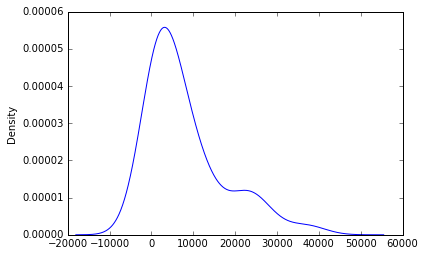

In [138]:
cat_counts.plot(kind='density')

In [165]:
apparel_category = cdf[cdf['category_name'].isin(['Baby & Kids', 'Clothing & Shoes'])]
apparel_category.shape
apparel_category.id.to_csv('apparel_category.csv', index=False)


In [166]:
house_category = cdf[cdf['category_name'].isin(['Furniture', 'Household', 'Home & Garden'])]
house_category.shape
house_category.id.to_csv('house_category.csv', index=False)

In [210]:
phones_base = cdf[cdf['category_name'] == 'Cell Phones']
from collections import Counter
l = map(lambda x: x.split(), phones_base.title.tolist())
c = Counter([item.lower() for sublist in l for item in sublist])
c.most_common(100)

In [224]:
def key_words_check(title, words):
    if len(set(title.split()).intersection(words)) > 0:
        return True
    return False

In [214]:
phone_words = set(['unlocked', 'iphone', 'galaxy', 'samsung', 'note', 'phone', 'lg', 'htc', 'verizon', 't-mobile', 'at&t', 
              'tmobile','nokia', 'mobile', 'sony', 'motorola', 'unlocled', 'lumia', 'smart', 'phones', 'nexus'])


In [167]:
phones_category = cdf[cdf['category_name'].isin(['Cell Phones', 'Electronics'])]
phones_category.shape
phones_category.id.to_csv('phones_category.csv', index=False)

In [227]:
phones_category[phones_category['title'].apply(lambda x: key_words_check(x, phone_words))]

,category,condition,description,distance,get_full_url,get_img_medium_height,get_img_medium_width,get_img_permalink_large,get_img_permalink_medium,get_img_permalink_small,...,state,title,category_id,category_name,condition_0,condition_20,condition_40,condition_60,condition_80,condition_100
73,"{u'id': 20, u'name': u'Cell Phones'}",40,,6,https://offerupnow.com/item/detail/96362909/vt...,402,300,https://d2j6tswx2otu6e.cloudfront.net/213ZVu7T...,https://d2j6tswx2otu6e.cloudfront.net/GWTShm3k...,https://d2j6tswx2otu6e.cloudfront.net/Pb6IQKyu...,...,3,Vtech home phone,20,Cell Phones,0,0,1,0,0,0
228,"{u'id': 20, u'name': u'Cell Phones'}",40,iphone 6 16gb factory unlocked . excellent con...,12,https://offerupnow.com/item/detail/96353431/ip...,533,300,https://d2j6tswx2otu6e.cloudfront.net/dLguw0AK...,https://d2j6tswx2otu6e.cloudfront.net/OLf0z6Jv...,https://d2j6tswx2otu6e.cloudfront.net/tlc-C5P7...,...,3,iphone 6 16gb factory unlocked .,20,Cell Phones,0,0,1,0,0,0
312,"{u'id': 1, u'name': u'Electronics'}",40,Gently used works great powerful enough to cha...,5,https://offerupnow.com/item/detail/96346042/na...,400,300,https://d2j6tswx2otu6e.cloudfront.net/qdKnA1H0...,https://d2j6tswx2otu6e.cloudfront.net/neb5-z-S...,https://d2j6tswx2otu6e.cloudfront.net/y0d-mxnp...,...,3,Napa blue fuel mobile portable power bank,1,Electronics,0,0,1,0,0,0
418,"{u'id': 20, u'name': u'Cell Phones'}",40,I have an iPhone 6s Plus gold 16gb looks very ...,25,https://offerupnow.com/item/detail/96338975/ip...,225,300,https://d2j6tswx2otu6e.cloudfront.net/3uUMCXPl...,https://d2j6tswx2otu6e.cloudfront.net/liDdR2bc...,https://d2j6tswx2otu6e.cloudfront.net/cqmxx33T...,...,4,iPhone 6s Plus gold factory unlocked,20,Cell Phones,0,0,1,0,0,0
488,"{u'id': 20, u'name': u'Cell Phones'}",0,LIKE NEW EXCELLENT CONDITION. was used for a m...,9,https://offerupnow.com/item/detail/96332341/sm...,300,300,https://d2j6tswx2otu6e.cloudfront.net/O0q_h1dF...,https://d2j6tswx2otu6e.cloudfront.net/oe-Shdgh...,https://d2j6tswx2otu6e.cloudfront.net/Hid8SMyy...,...,3,smart talk pre paid,20,Cell Phones,1,0,0,0,0,0
609,"{u'id': 20, u'name': u'Cell Phones'}",40,unlocked iphone 5s \nNO TRADES CASH ONLY\n\nfu...,27,https://offerupnow.com/item/detail/96320777/un...,533,300,https://d2j6tswx2otu6e.cloudfront.net/yzhd94Zs...,https://d2j6tswx2otu6e.cloudfront.net/QMaKBy6M...,https://d2j6tswx2otu6e.cloudfront.net/G8iRUXOQ...,...,3,unlocked iphone 5s,20,Cell Phones,0,0,1,0,0,0
610,"{u'id': 20, u'name': u'Cell Phones'}",40,unlocked lg g4 \nNO TRADES CASH ONLY\n\nfully ...,27,https://offerupnow.com/item/detail/96320539/un...,533,300,https://d2j6tswx2otu6e.cloudfront.net/_o039OuE...,https://d2j6tswx2otu6e.cloudfront.net/_j8VKrkN...,https://d2j6tswx2otu6e.cloudfront.net/P4BQsaJY...,...,3,unlocked LG G4,20,Cell Phones,0,0,1,0,0,0
615,"{u'id': 20, u'name': u'Cell Phones'}",40,fully unlocked iphone 6 \nNO TRADES CASH ONLY\...,27,https://offerupnow.com/item/detail/96320273/un...,533,300,https://d2j6tswx2otu6e.cloudfront.net/RzdOZiCo...,https://d2j6tswx2otu6e.cloudfront.net/vTYXlUaF...,https://d2j6tswx2otu6e.cloudfront.net/Vi_XWLUR...,...,3,unlocked iphone 6,20,Cell Phones,0,0,1,0,0,0
617,"{u'id': 20, u'name': u'Cell Phones'}",40,samsung note 1 unlocked \nUnlocked works on an...,27,https://offerupnow.com/item/detail/96320011/un...,533,300,https://d2j6tswx2otu6e.cloudfront.net/DiUA1Yn9...,https://d2j6tswx2otu6e.cloudfront.net/es7P_YZl...,https://d2j6tswx2otu6e.cloudfront.net/imaQT4PX...,...,3,unlocked note 1 samsung,20,Cell Phones,0,0,1,0,0,0
748,"{u'id': 20, u'name': u'Cell Phones'}",40,unlocked iphone 5c each one is 165\n\nUnlocked...,27,https://offerupnow.com/item/detail/96304561/un...,533,300,https://d2j6tswx2otu6e.cloudfront.net/cG9z7ZgH...,https://d2j6tswx2otu6e.cloudfront.net/wtE_4nma...,https://d2j6tswx2otu6e.cloudfront.net/NyjUNEXm...,...,3,unlocked iphone 5c,20,Cell Phones,0,0,1,0,0,0


In [219]:
phones = phones_category[any(y in map(lambda x: x.split(), phones_category.title.tolist()) for y in phone_words)]

SyntaxError: invalid syntax (<ipython-input-219-cb6ca5ccf95c>, line 1)

In [222]:
[y in map(lambda x: x.split(), phones_category.title.tolist()) for y in phone_words]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [223]:
map(lambda x: x.split(), phones_category.title.tolist())

[[u'Surface', u'pro', u'3', u'128gb'],
 [u'K'],
 [u'Verizon', u'Samsung', u'Galaxy', u's6'],
 [u'Stylus', u'for', u'kids'],
 [u'CANON', u'Powershot', u'ELPH', u'340', u'HS'],
 [u'JBL', u'synchros', u'reflect', u'sport', u'earbuds'],
 [u'Vtech', u'home', u'phone'],
 [u'Galaxy', u'tab3'],
 [u'refrigerator'],
 [u'For', u'iPhone', u'6', u'or', u'6s'],
 [u'For', u'iPhone', u'6', u'Plus', u'and', u'6s', u'plus', u'(blue)'],
 [u'For', u'iPhone', u'6plus', u'and', u'6s', u'plus'],
 [u'VERIZON', u'BASIC', u'PHONES'],
 [u'APPLE', u'OEM', u'60W', u'MAGSAFE', u'POWER', u'ADAPTER'],
 [u'Wii'],
 [u'Samsung', u'Galaxy', u'Grand', u'Prime(G530)'],
 [u'PIVOTAL', u'TRACKER', u'1'],
 [u'Appliances'],
 [u'Kickers', u'subs', u'amp', u'2', u'12"', u'box'],
 [u'Sylvania', u'TV'],
 [u'iphone', u'6', u'16gb', u'factory', u'unlocked', u'.'],
 [u'Halo', u'nightfall'],
 [u'iPad', u'Pro', u'9.7', u'32GB', u'Wi-Fi'],
 [u'Mp3', u'player'],
 [u'Napa', u'blue', u'fuel', u'mobile', u'portable', u'power', u'bank'],
 [u'

1. Condition
- condition 380107 non-null int64 - no missing values
- value range: [0, 20, 40, 60, 80, 100], so it looks like categorical.
- Create 6 features with conditions

In [101]:
condition_counts = cdf['condition'].value_counts()

In [102]:
condition_counts

40     268919
100     71506
60      24276
80       9918
0        4423
20       1065
Name: condition, dtype: int64

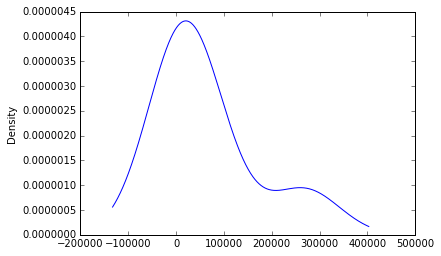

In [113]:
condition_counts.plot(kind='density')

In [112]:
for i in  [0, 20, 40, 60, 80, 100]:
    cdf['condition_' + str(i)] =  cdf.condition.apply(lambda x: 1 if x == i else 0 )